In [229]:
import pandas as pd
import datetime as dt

data = pd.read_csv('project_4.csv')
data1 = pd.read_csv('project_4_1.csv')

In [230]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   flight_id            245 non-null    int64  
 1   scheduled_departure  245 non-null    object 
 2   city_departure       245 non-null    object 
 3   city_arrival         245 non-null    object 
 4   aircraft_model       245 non-null    object 
 5   fare_conditions      236 non-null    object 
 6   available_seats      245 non-null    int64  
 7   price_seat           236 non-null    float64
 8   occupied_seats       245 non-null    int64  
 9   fullness_flight      236 non-null    float64
 10  revenue_flight       236 non-null    float64
 11  free_seats           245 non-null    int64  
 12  lost_profit          236 non-null    float64
dtypes: float64(4), int64(4), object(5)
memory usage: 25.0+ KB


In [231]:
data.head()

,flight_id,scheduled_departure,city_departure,city_arrival,aircraft_model,fare_conditions,available_seats,price_seat,occupied_seats,fullness_flight,revenue_flight,free_seats,lost_profit
0,136119,2017-01-03T10:05:00Z,Anapa,Moscow,Boeing 737-300,Business,12,36600.000000,11,91.0,402600.0,1,36600.000000
1,136119,2017-01-03T10:05:00Z,Anapa,Moscow,Boeing 737-300,Economy,118,12258.823529,102,86.0,1250400.0,16,196141.176471
2,136120,2017-02-24T10:05:00Z,Anapa,Moscow,Boeing 737-300,Business,12,36600.000000,11,91.0,402600.0,1,36600.000000
3,136120,2017-02-24T10:05:00Z,Anapa,Moscow,Boeing 737-300,Economy,118,12273.469388,98,83.0,1202800.0,20,245469.387755
4,136122,2017-01-08T10:05:00Z,Anapa,Moscow,Boeing 737-300,Business,12,36600.000000,10,83.0,366000.0,2,73200.000000


### Удаление данных о рейсах в Новокузнецк

В  полученном из базы данных датасете в столбцах с информацией о бронировании, билетах и посадочных талонов имеется одинаковое количество пропусков - 9 пропусков. В данных о рейсах пропусков нет.

In [232]:
data[data.fullness_flight.isnull()].city_arrival

118    Novokuznetsk
119    Novokuznetsk
120    Novokuznetsk
121    Novokuznetsk
122    Novokuznetsk
123    Novokuznetsk
124    Novokuznetsk
125    Novokuznetsk
126    Novokuznetsk
Name: city_arrival, dtype: object

Все пропуски относятся к рейсам в Новокузнецк. Учитывая то, что пропуски имеют **не случайный** характер, а относятся к одному сегменту данных, заполнять их используя расчетные методы нецелесообразно. Такие данные необходимо заполнять путем восстановления отсутствующего сегмента в базе данных. Поэтому все строки относящиеся к рейсам в Новокузнецк удаляем. Оценить прибыльность или убыточность рейсов без информации о проданных на них билетов не возможно.

In [233]:
data.city_arrival.unique()

array(['Moscow', 'Novokuznetsk', 'Belgorod'], dtype=object)

In [234]:
data.flight_id.nunique()

127

In [235]:
data.dropna(inplace = True)
data.city_arrival.unique()
# После удаления пропусков остались рейсы только в Москву и Белгород.

array(['Moscow', 'Belgorod'], dtype=object)

In [236]:
data.flight_id.nunique()

118

In [237]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236 entries, 0 to 244
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   flight_id            236 non-null    int64  
 1   scheduled_departure  236 non-null    object 
 2   city_departure       236 non-null    object 
 3   city_arrival         236 non-null    object 
 4   aircraft_model       236 non-null    object 
 5   fare_conditions      236 non-null    object 
 6   available_seats      236 non-null    int64  
 7   price_seat           236 non-null    float64
 8   occupied_seats       236 non-null    int64  
 9   fullness_flight      236 non-null    float64
 10  revenue_flight       236 non-null    float64
 11  free_seats           236 non-null    int64  
 12  lost_profit          236 non-null    float64
dtypes: float64(4), int64(4), object(5)
memory usage: 25.8+ KB


### Общая оценка рейсов из Анапы зимой 2017 года.

In [238]:
data[data.city_arrival == 'Moscow'].flight_id.nunique()

59

In [239]:
data[data.city_arrival == 'Belgorod'].flight_id.nunique()

59

Без учета рейсов в Новокузнецк авиакомпания осуществила за зиму 2017 года 118 рейсов. В Москву и Белгород было совершено одинаковое количество рейсов.

In [240]:
data.groupby(['city_arrival']).aircraft_model.unique()

city_arrival
Belgorod    [Sukhoi Superjet-100]
Moscow           [Boeing 737-300]
Name: aircraft_model, dtype: object

В Москву выполнялись рейсы всегда на Boeing 737-300, а в Белгород - на Sukhoi Superjet-100.

### Оценка влияния времени вылета на заполняемость рейса.
Часто бывает, что рейс имеющий неудобное время вылета заполнен не полностью. Проверим эту версию.

In [241]:
data['scheduled_departure'] = pd.to_datetime(data['scheduled_departure'])
# Приведение данных в столбцах с датой и временем к типу datetime

In [242]:
data['departure_time'] = data['scheduled_departure'].dt.time
# Создаем столбец с плановым временем отправления
# для удобной проверки времени отправления в разные даты.

In [243]:
data[data.city_arrival == 'Moscow'].departure_time.unique()
# У всех рейсов в Москву одно время вылета - 10:05

array([datetime.time(10, 5)], dtype=object)

In [244]:
data[data.city_arrival == 'Belgorod'].departure_time.unique()
# У всех рейсов в Белгород одно время вылета - 09::25

array([datetime.time(9, 25)], dtype=object)

Так как время вылета и в Москву и в Белгород во все даты одно и то же, можно сказать, что заполняемость самолетов не зависила от времени вылета. Значит время вылета в дальнейшем анализе можно не учитывать.

### Оценка заполняемости рейсов

#### Зависимость заполняемости от города.

<AxesSubplot:xlabel='city_arrival'>

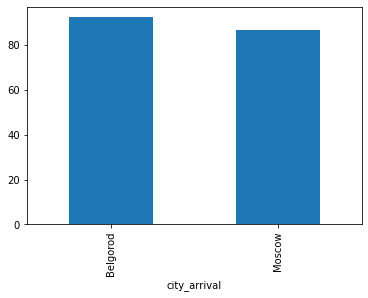

In [245]:
data.groupby('city_arrival').fullness_flight.mean().plot(kind = 'bar')

In [246]:
round(data[data.city_arrival == 'Belgorod'].fullness_flight.mean(),1)

92.4

In [247]:
round(data[data.city_arrival == 'Moscow'].fullness_flight.mean(),1)

86.9

Средняя заполняемость рейсов в Белгород на 5% выше чем в Москву.

#### Зависимость заполняемости от города и класса обслуживания

<AxesSubplot:xlabel='city_arrival,fare_conditions'>

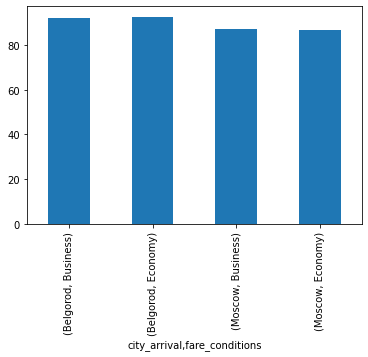

In [248]:
data.groupby(['city_arrival','fare_conditions']).fullness_flight.mean().plot(kind = 'bar')

На графике видно, что заполняемость рейса не зависит от класса обслуживания. При этом нужно помнить, что в моделях самолетов летающих в эти города одинаковое количество мест бизнесс класса.

#### Зависимость заполняемости от даты вылета
Для оценки влияния даты вылета на заполняемость рейса создадим новый столбец с датой без времени, так как время вылета всегда одинаково.

In [249]:
data['departure_date'] = data['scheduled_departure'].dt.date

<AxesSubplot:xlabel='departure_date'>

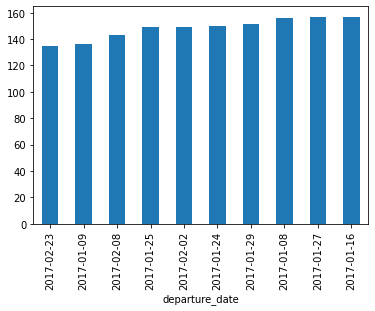

In [250]:
data[data.city_arrival == 'Moscow'].groupby(
    'departure_date').fullness_flight.sum().sort_values(
    ).head(10).plot(kind = 'bar')

10 самых незаполненных рейсов в Москву.

<AxesSubplot:xlabel='departure_date'>

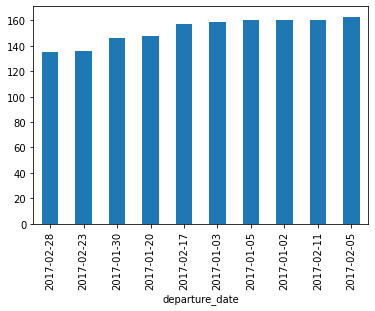

In [251]:
data[data.city_arrival == 'Belgorod'].groupby(
    'departure_date').fullness_flight.sum().sort_values(
    ).head(10).plot(kind = 'bar')

10 самых незаполненных рейсов в Белгород.

### Оценка упущенной выгоды рейса.
Упущенная выгода расчитывалась как стоимость непроданных билетов.
#### Зависимость упущенной выгоды от города назначения.

<AxesSubplot:xlabel='city_arrival'>

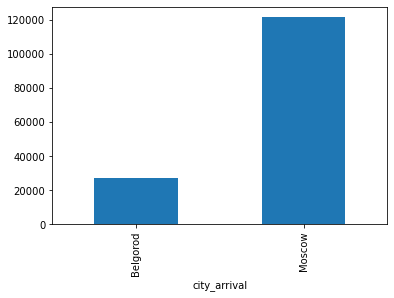

In [252]:
data.groupby('city_arrival').lost_profit.mean().plot(kind = 'bar')

In [253]:
round(data[data.city_arrival == 'Belgorod'].lost_profit.mean(), 0)

27439.0

In [254]:
round(data[data.city_arrival == 'Moscow'].lost_profit.mean(), 0)

121631.0

В среднем упущенная выгода от рейсов в Москву почти в 4.5 раз выше чем в Белгород.

#### Зависимость упущенной выгоды от города и класса обслуживания

<AxesSubplot:xlabel='city_arrival,fare_conditions'>

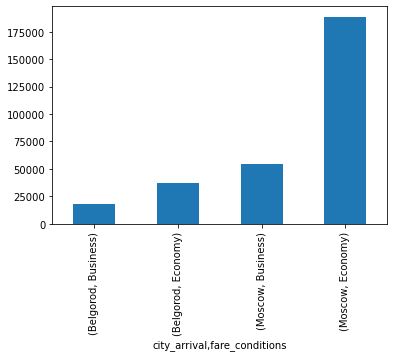

In [255]:
data.groupby(['city_arrival','fare_conditions']).lost_profit.mean().plot(kind = 'bar')

Самая большая недополученная прибыль от эконом класса в Москву.

#### Зависимость упущенной выгоды от даты вылета

<AxesSubplot:xlabel='departure_date'>

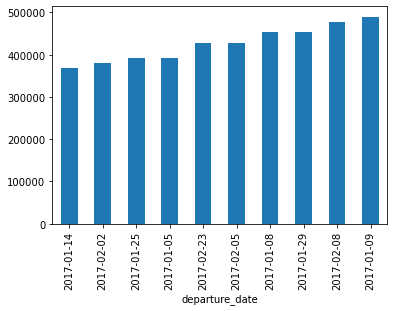

In [256]:
data[data.city_arrival == 'Moscow'].groupby(
    'departure_date').lost_profit.sum().sort_values(
    ).tail(10).plot(kind = 'bar')

10 самых неприбыльных дней за зиму на рейсе в Москву.

<AxesSubplot:xlabel='departure_date'>

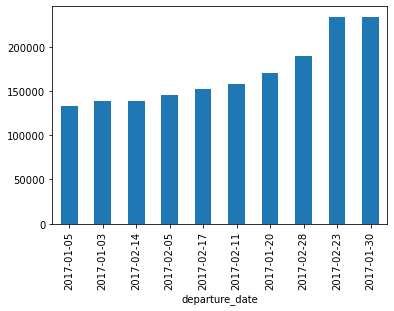

In [257]:
data[data.city_arrival == 'Belgorod'].groupby(
    'departure_date').lost_profit.sum().sort_values(
    ).tail(10).plot(kind = 'bar')

10 самых неприбыльных дней за зиму на рейсе в Белгород.

### Оценка выручки от рейса

#### Зависимость средней выручки от города назначеия

<AxesSubplot:xlabel='city_arrival'>

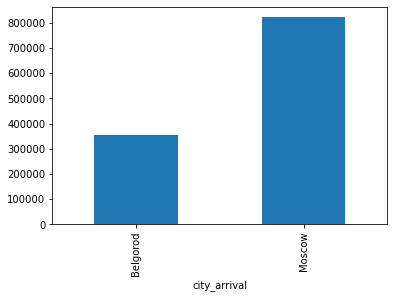

In [258]:
data.groupby('city_arrival').revenue_flight.mean().plot(kind = 'bar')

In [259]:
round(data[data.city_arrival == 'Belgorod'].revenue_flight.mean(), 2)

355217.8

In [260]:
round(data[data.city_arrival == 'Moscow'].revenue_flight.mean(), 2)

821288.14

Средняя выручка от рейса в Москву 2.3 раза выше чем в Белгород.

#### Зависимость средней выручки от города и класса обслуживания.

<AxesSubplot:xlabel='city_arrival,fare_conditions'>

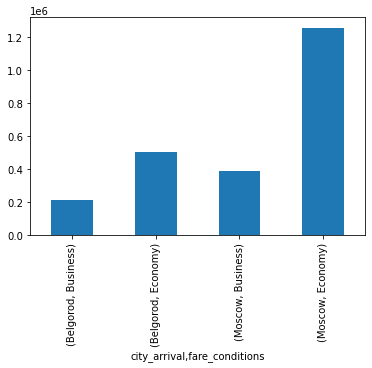

In [261]:
data.groupby(['city_arrival','fare_conditions']).revenue_flight.mean().plot(kind = 'bar')

Самая большая выручка от эконом класса в Москву, самая низкая - от бизнесс класса в Белгород.

#### Зависимость выручки от даты

<AxesSubplot:xlabel='departure_date'>

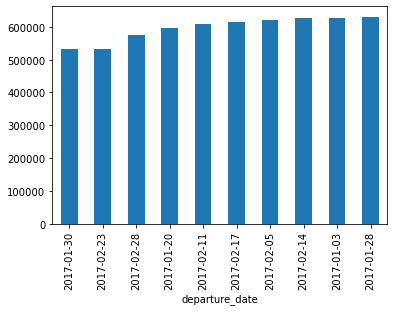

In [262]:
data[data.city_arrival == 'Belgorod'].groupby(
    'departure_date').revenue_flight.sum().sort_values(
    ).head(10).plot(kind = 'bar')

10 дней с самой низкой выручкой в Белгород.

<AxesSubplot:xlabel='departure_date'>

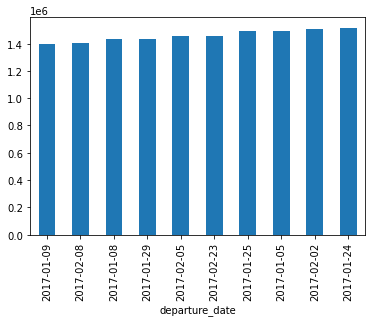

In [263]:
data[data.city_arrival == 'Moscow'].groupby(
    'departure_date').revenue_flight.sum().sort_values(
    ).head(10).plot(kind = 'bar')

10 дней с самой низкой выручкой в Москву.

**Рейсы в Москву хотя и приносят больше выручки в абсолютных цифрах за счет большей стоимости билетов, но часто оказываются незаполненными пассажирами, поэтому именно на рейсах в Москву авиакомпания недополучает выручку. Возможно проблему не полной заполненности рейсов в Москву можно было бы решить заменой Боинга на более компактную модель или уменьшением числа рейсов в Москву в зимнее время.**

In [264]:
data1

,city_departure,city_arrival,aircraft_model,range,flight_time
0,Anapa,Belgorod,Sukhoi Superjet-100,3000,0 years 0 mons 0 days 0 hours 50 mins 5.084746...
1,Anapa,Moscow,Boeing 737-300,4200,0 years 0 mons 0 days 1 hours 39 mins 49.83050...
2,Anapa,Novokuznetsk,Boeing 737-300,4200,0 years 0 mons 0 days 5 hours 6 mins 40.00 secs


In [266]:
fuel_flow_model = {'Sukhoi Superjet-100': 1.700, 'Boeing 737-300': 2.650}
# Расход топлива в тоннах в час разными моделями самолетов.
flight_time = {'Moscow': 1.65, 'Belgorod': 0.83, 'Novokuznetsk': 5.1}
# Длительность полета в часах от Анапы до разных городов.

# Стоимость авиационного керосина в Анапе в 2017 г. 41637 руб/тонна.
fuel_flow_city = {'Moscow': 4.372, 'Belgorod': 4.411, 'Novokuznetsk': 13.515}
# Расход топлива в тоннах до разных городов.
fuel costs = {'Moscow': 182078, 'Belgorod': 58750, 'Novokuznetsk': 562724}

Расчеты для оценки расходов на топливо для рассматриваемых рейсов гораздо проще и быстрее провести вручную, так как нас интересуют только два города.

## Запросы SQL для создания дадасета

select
    f.flight_id,
    f.scheduled_departure,
    ap1.city as city_departure,
    ap.city as city_arrival,
    ac.model as aircraft_model,
    tf.fare_conditions,
    count(distinct s.seat_no) as available_seats,
    -- компоновка самолета по количеству мест разного класса обслуживания
    avg(tf.amount) as price_seat,
    -- цена одного места
    count(distinct bp.seat_no) as occupied_seats,
    -- количество проданных мест
    count(distinct bp.seat_no) * 100 / nullif(count(distinct s.seat_no),0) as fullness_flight,
    -- заполненность мест в самолете на рейсе
    -- nullif используется из-за нулевых значений в рейсах на Новокузнецк
    count(distinct bp.seat_no) * avg(tf.amount) as revenue_flight,
    -- выручка от проданных билетов по каждому классу отдельно
    count(distinct s.seat_no) - count(distinct bp.seat_no) as free_seats,
    -- нераспроданные места
    count(distinct s.seat_no) * avg(tf.amount) - count(distinct bp.seat_no) * avg(tf.amount) as lost_profit
    -- упущенная выгода по каждому классу
    
from
    dst_project.flights as f
        join dst_project.airports as ap on f.arrival_airport = ap.airport_code
            join dst_project.airports as ap1 on f.departure_airport = ap1.airport_code
                join dst_project.aircrafts as ac on f.aircraft_code = ac.aircraft_code
                    left join dst_project.ticket_flights as tf on f.flight_id = tf.flight_id
                        left join dst_project.boarding_passes as bp on tf.ticket_no = bp.ticket_no 
                                                                    and tf.flight_id = bp.flight_id
                            left join dst_project.tickets as t on tf.ticket_no = t.ticket_no
                                    left join dst_project.bookings as b on t.book_ref = b.book_ref
                                        left join dst_project.seats as s on ac.aircraft_code = s.aircraft_code
                                                                    and s.fare_conditions = tf.fare_conditions 
    /* В запросе объединены все таблицы из базы данных dst_project. Эту конструкцию можно использовать для 
    написания других запросов к этой базе данных, если понадобится дополнительная информация. Однако в итоговый 
    датасет включена информация не из всех таблиц, так как для ответа на поставленный вопрос она будет избыточной.
    Кроме того отказ от всей полноты базы данных дал возможность сгруппировать нужную информацию и представить ее 
    в удобном виде, который не требует дополнительной обработки на Python.
    
    Начиная с таблицы Ticket_flights присоединяем последующие таблицы по left join, так как в базе данных имеются 
    ресы в Новокузнецк, по которым нет данных о продаже билетов. */   
    
where f.departure_airport = 'AAQ'
    and (date_trunc('month', f.scheduled_departure) in ('2017-01-01','2017-02-01', '2017-12-01'))
    and f.status not in ('Cancelled')
    -- Условия проекта: выполненные зимой 2017 года рейсы из Анапы.
group by 
    f.flight_id,
    f.scheduled_departure,
    ap1.city,
    ap.city,
    ac.model,
    tf.fare_conditions,
    s.fare_conditions
_________________________________________________________________________________________________________________
    
    ЗАПРОС для получения справочной информации о предельной дальности полета модели самолета и средней продолжительности
полетов от Анапы до Москвы, Белгорода и Новокузнецка. Эта информация одинакова для всех рейсов в указанные города,
имеет справочный характер, поэтому нет смысла перегружать ею основной датасет. Информация о расстоянии между 
аэропортами также носит справочный характер и общедоступна, поэтому нет смысла расчитывать ее по координатам 
аэропортов.

select
    --f.flight_id,
    ap1.city as city_departure,
    ap.city as city_arrival,
    ac.model as aircraft_model,
    ac.range,
    avg(f.actual_arrival - f.actual_departure) as flight_time
    
from
    dst_project.flights as f
        join dst_project.airports as ap on f.arrival_airport = ap.airport_code
            join dst_project.airports as ap1 on f.departure_airport = ap1.airport_code
                join dst_project.aircrafts as ac on f.aircraft_code = ac.aircraft_code
                
where f.departure_airport = 'AAQ'
    and (date_trunc('month', f.scheduled_departure) in ('2017-01-01','2017-02-01', '2017-12-01'))
    and f.status not in ('Cancelled')
    
group by
    ap1.city,
    ap.city,
    ac.model,
    ac.range
